# Загрузка и установка дополнительных библиотек

In [ ]:
!nvidia-smi

Thu Jan 27 20:27:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install numpy
!pip install pandas

In [ ]:
!pip install  arff2pandas
!pip install -U pandas-profiling
!pip install sklearn
!pip install seaborn

  Created wheel for arff2pandas: filename=arff2pandas-1.0.1-py3-none-any.whl size=2197 sha256=f866d8ad46b036502c65d565702a1afa228f7c752080ed995cb32616fc9d415f
  Stored in directory: /root/.cache/pip/wheels/f8/de/20/0a537c8c7fb37c4d84b752352ce3ae40c801f2888408fd28ea
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11732 sha256=aedf1c5fc83e72f6f3174f8b7dbf9164ed0c334b3861c3561b72406ef7d8cb25
  Stored in directory: /root/.cache/pip/wheels/1f/0f/15/332ca86cbebf25ddf98518caaf887945fbe1712b97a0f2493b
Successfully built arff2pandas liac-arff
     |████████████████████████████████| 261 kB 5.3 MB/s 
     |████████████████████████████████| 303 kB 31.1 MB/s 
     |████████████████████████████████| 596 kB 19.8 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 10.9 MB 15.7 MB/s 
     |████████████████████████████████| 3.1 MB 32.2 MB/s 
     |████████████████████████████████| 102 kB 8.1 MB/s 
     |█████████████████████

Скачиваем архив с датасетами

In [ ]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
!unzip -qq ECG5000.zip

Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /content/ECG5000.zip
100% 10.6M/10.6M [00:00<00:00, 80.9MB/s]


Импортируем необходимые для работы модули и библиотеки.

In [ ]:
import torch

На базе PyTorch будет происходить моделирование нейронной сети LSTM автоэнкодера для обнаружения аномалий на временном отрезке данных.

In [ ]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from arff2pandas import a2p

Все остальные библиотеки нужны для разметки данных, математических вычислений, отображение инфографики, манипуляций с данными.

In [ ]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Настройка параметров отображение инфографики, генератора случайных чисел на новую последовательность, путём задавания RANDOM_SEED. Обозначаем для PyTorch вычислительный юнит графического процессора с помощью архитектуры "Cuda", если данное вычисление невозможно, то PyTorch будет производить вычисления с помощью Центрального процессора системы.

In [ ]:
with open('ECG5000_TRAIN.arff') as f:
  train = a2p.load(f)

with open('ECG5000_TEST.arff') as f:
  test = a2p.load(f)

Загружаются данные в обучающую и тренировочную выборки.

In [ ]:
df = pd.concat([train,test],ignore_index=True)
df = df.sample(frac=1.0)
print(df.head())


      att1@NUMERIC  att2@NUMERIC  ...  att140@NUMERIC  target@{1,2,3,4,5}
1501      1.469756     -1.048520  ...       -1.039932                   1
2586     -1.998602     -3.770552  ...        0.799517                   1
2653     -1.187772     -3.365038  ...       -0.824489                   1
1055      0.604969     -1.671363  ...        0.023843                   1
705      -1.197203     -3.270123  ...        1.734676                   1

[5 rows x 141 columns]


Создаётся общий датафрейм

In [ ]:
CLASS_NORMAL = 1
class_name = ['Normal','R on T','PVC','SP','UB']

Создаётся кортеж классов.

In [ ]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

Переименновывается последняя колонка датафрейма, для лучшего ориентирования в нём (датафрейме)

In [ ]:
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

Проверка колчиство примеров для каждого класса сердцебиения

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


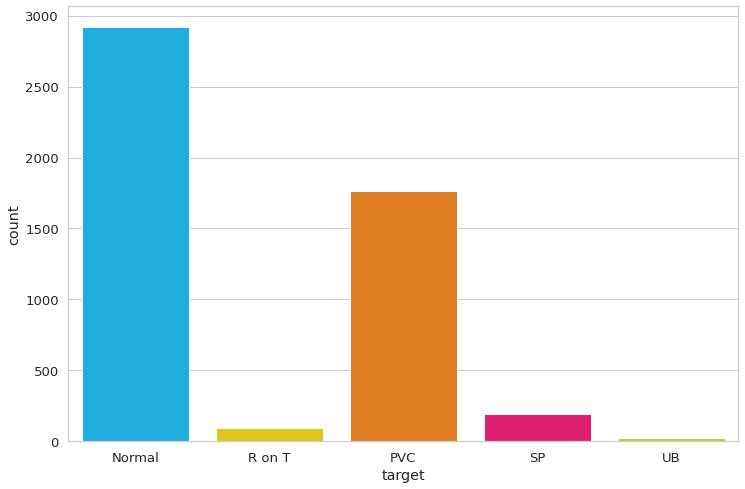

In [ ]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_name);

По графикам видно, что большее количество примеров приходится на нормальное сердцебиение. На них как будет производится последующее обучение.

In [ ]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

Выведем инфорграфику усредненного временного ряда для каждого класса сердцебиения

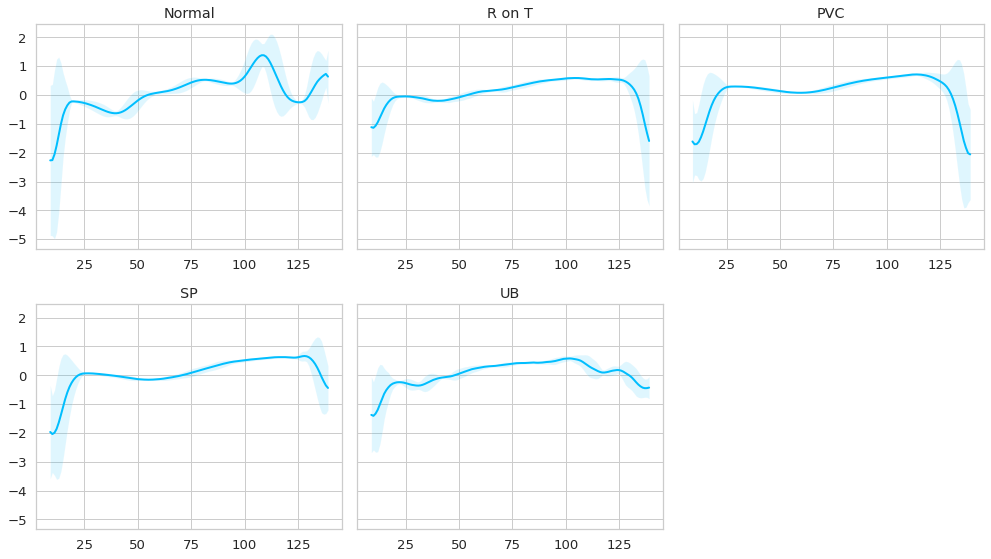

In [ ]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_name[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

Поведение класса "Normal" отличается от других, что даёт возможность обучения модели на загруженных данных

In [ ]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

Выделение класса "Normal" в отдельный датафрейм

In [ ]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

Остальные классы переходят в датафрейм для аномалий

In [ ]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=RANDOM_SEED
)

Класс "Normal" разделяется на три датафрейма: обучение, валидация и тестирование.

In [ ]:
def create_dataset(df):
  sequences = df.astype(np.float32).to_numpy().tolist()
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features

Вводится дополнительная функция для форматирования датасетов. Это необходимо для исплоьзования датафреймов, как тензеров, при обучении  автоэнкодера.

In [ ]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

Каждый временной ряд будет конвертирован в двухмерный тензор (длина последовательности Х количество признаков) 

# Автоэнкодер

Основная архитектура автоэнкодера содержит в себе два компонента. Энкодер, который сжимает входные данные, и Декодер, который после реконструеирует их. 

In [ ]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

В реализации энкодера используется две LSTM слоя для сжатия входных временных рядов 

In [ ]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)


Декодер содержит два слоя LSTM и выходный слой, который выводит реконстрированные данные

Объединение двух модулей в одну нейронную сеть

In [ ]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

Создание сущности модели нейронной сети

In [ ]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

# Обучение

Создаётся вспомогательная функция для процесса обучения, где настраиваются такие параметры как: количество эпох, величина фунцкии потерь, валидация функции потерь.

      att1@NUMERIC  att2@NUMERIC  ...  att140@NUMERIC  target@{1,2,3,4,5}
1501      1.469756     -1.048520  ...       -1.039932                   1
2586     -1.998602     -3.770552  ...        0.799517                   1
2653     -1.187772     -3.365038  ...       -0.824489                   1
1055      0.604969     -1.671363  ...        0.023843                   1
705      -1.197203     -3.270123  ...        1.734676                   1

[5 rows x 141 columns]
1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64
(2919, 140)
(2081, 140)
Epoch 1: train loss 67.98850930616386 val loss 57.15424116479659
Epoch 2: train loss 55.46555044304119 val loss 54.72982056393151
Epoch 3: train loss 54.95946759381923 val loss 54.39005289956571
Epoch 4: train loss 54.81948209068363 val loss 54.45671141432414
Epoch 5: train loss 54.639888492816404 val loss 53.738122516931526
Epoch 6: train loss 53.075111476801325 val loss 50.89174007637102
Epoch 7: train loss 46.859430387297834

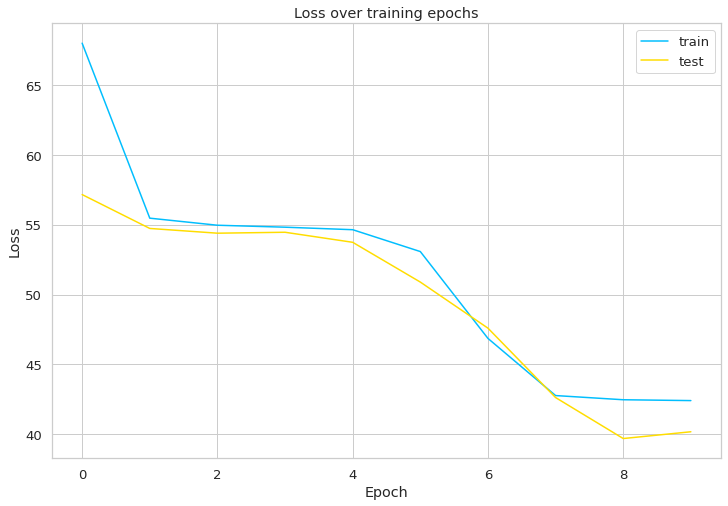

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:
        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

model, history = train_model(
  model,
  train_dataset,
  val_dataset,
  n_epochs=10
)


ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show()

В каждую эпоху процесс обучения передаёт модели все обучающие примеры и оценивает произовадительность на проверочном наборе. Модель при обучении распознаёт только одну последовательность за раз. Также, записываются потери наборов обучения и валидации в процессе. 

Минимизируется L1Loss, который измеряет среднюю абсолютную ошибку. Так как при среднеквадратичной ошибке реконструированные данные не дают такой картины. 

Проводим обучение модели.





Сохранение обученной модели

In [ ]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

Создаёются функция для предсказывания. С её помощью будет видно сколько ошибок будет на выходе после реконструирования

In [ ]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

Эта функция проходит через каждый пример в датасете и записывает величены предсказывания и потери. Далее на изображении можно увидеть потери.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


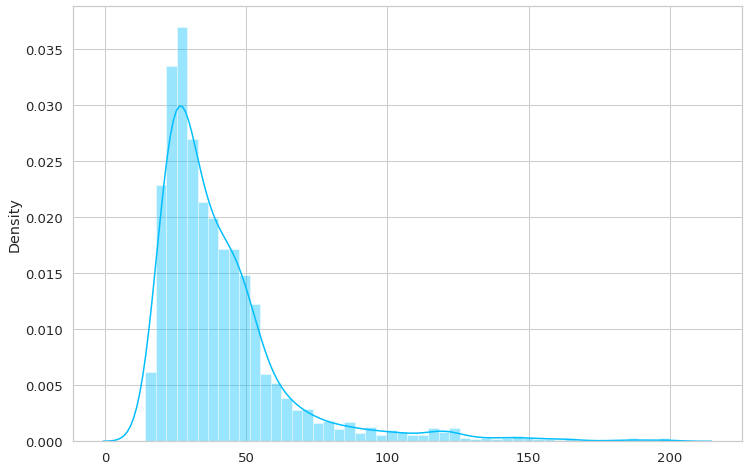

In [ ]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [ ]:
THRESHOLD = 26

# Оценка

Используя пороговое значение = 26, решается задача уже бинарной классификации.


Если потеря реконструкции для примера ниже порогового значения, то это классифицируется как нормальное средцебиение. Иначе классифицируется как аномалия. 


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


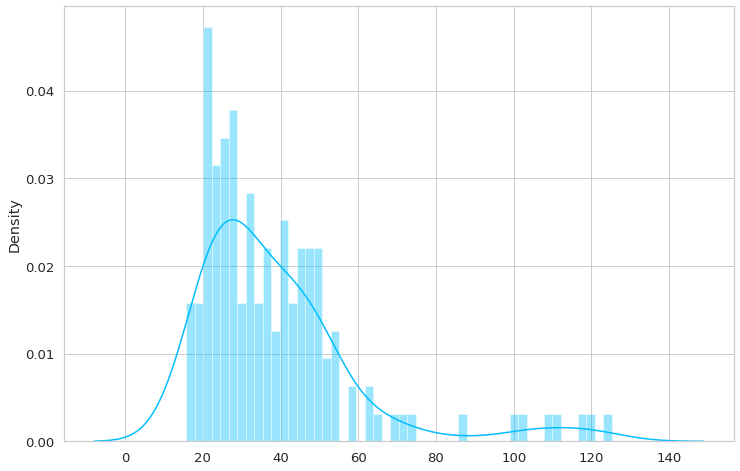

In [ ]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

Нормальное сердцебиение. Проверка качества работы модели по определению нормального сердцебиения. Используется класс "Normal" из тестового набора.

In [ ]:
correct = sum(l <= 26 for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 43/145


Повторяем предидущие действия для примеров аномалий. Ограничим из количество количетсвом нормального сердцебиения.

In [ ]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

Теперь проведём предсказание модели на новом подмножестве.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


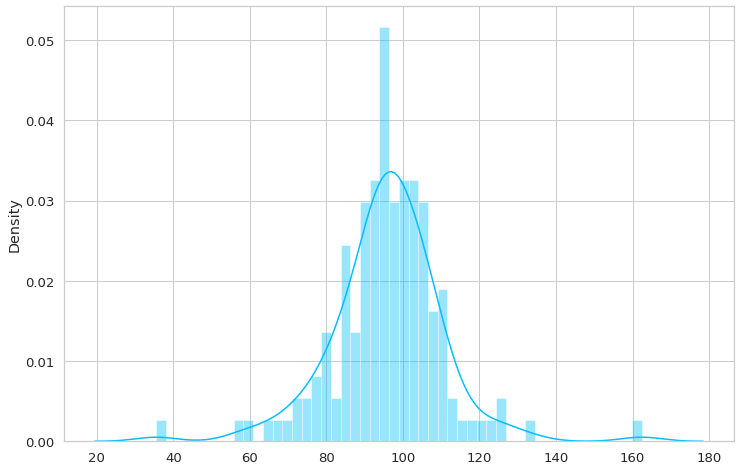

In [ ]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

In [ ]:
correct = sum(l > 26 for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 145/145


Все аномальные ритмы сердце были определены верно. Настройка порогового значения сильно зависит от количества эпох обучения. В данном случае не представилось возможности настолько чётко обучить модель. Для этого требуется много вычислительных мощностей и времени. Но ложноположительные результаты, тоже хороший показатель. Так как, все аномалии зарегитрированы, то дополнительное обследование пациентов с ложноположительными результатами может выдать более глубокую аномалию. 

# Эксперименты

Наложим реальные и реконструированные значения временных рядов, чтобы увидеть насколько они близки. Данное действие проводиться не некторого количетсва нормальных и аномальных случаев.

In [ ]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

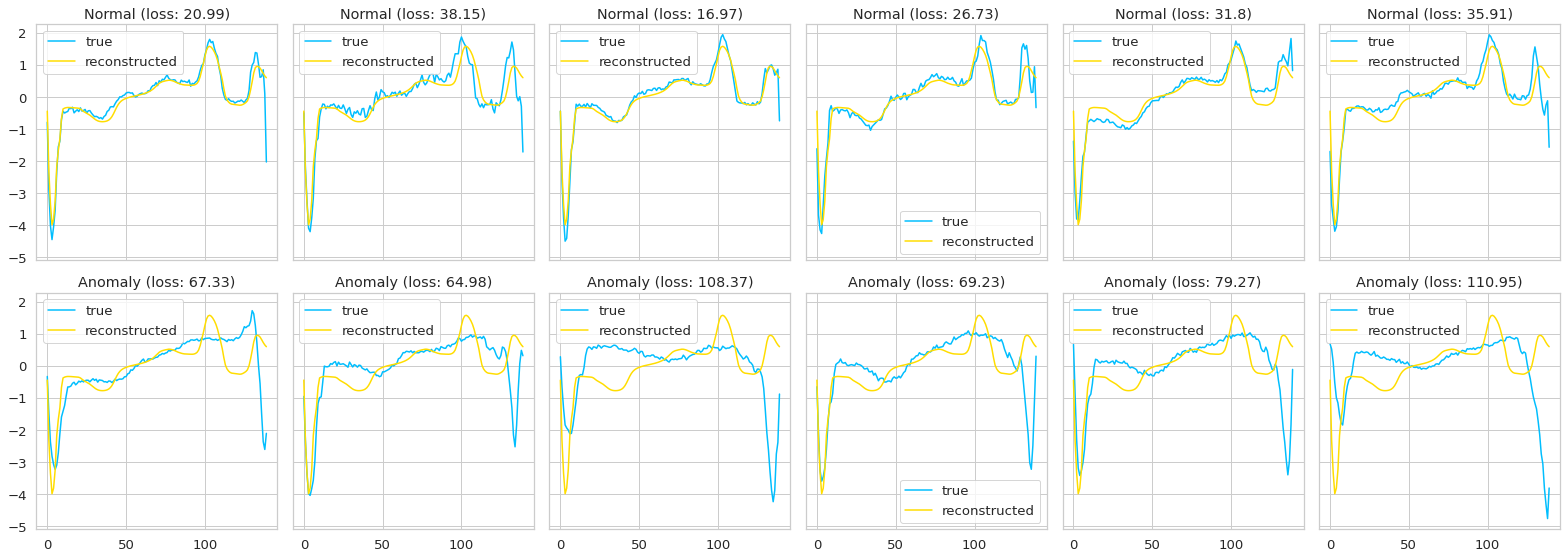

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();